In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from multiprocessing import Pool
import os
from my_utils_for_ridge import *
import pickle

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open("srt/stimulus.pcl", 'rb') as f:
    stimulus = pickle.load(f)

In [3]:
U, S, Vh = np.load('results/USVh.npy')

In [4]:
mri = np.load("fmri/mri2_all3_preprocessed.npy")

In [5]:
mri.shape

(132, 175, 48, 3599)

In [7]:
x_range = range(0, 132)
y_range = range(0, 175)
coordinates = [(x, y) for x in x_range for y in y_range]
print len(coordinates)

23100


Do after truble stop

In [8]:
fresults = os.listdir('results/sub3/0_500_prep3/')
#coordinates = [(x, y) for x in range(30, 131) for y in range(18, 142)]
fcor = map(lambda x: '{}_{}.npy'.format(x[0], x[1]), coordinates)
fcor = set(fcor)
fcor = fcor - set(fresults)

new_coord = map(lambda x: x[:-4].split('_'), fcor)
new_coord = map(lambda x: map(int, x), new_coord)
print len(new_coord)

0


In [9]:
def ridge_corr_z(Rstim, Pstim, Rresp, Presp, U, S, Vh, alphas, filename, 
                 corrmin=0.2,use_corr=True, mri=mri):
    ## Precompute some products for speed
    #print "here"
    UR = np.dot(U.T, Rresp)
    PVh = np.dot(Pstim, Vh.T)
    
    zPresp = zs(Presp)
    Prespvar = Presp.var(0)
    Rcorrs = [] ## Holds training correlations for each alpha
    
    result = list()
    for a in alphas:
        D = S/(S ** 2 + a ** 2) ## Reweight singular vectors by the (normalized?) ridge parameter
        diag = mult_diag(D, PVh, left=False)
        #print "after diag", diag.shape, UR.shape
        pred = np.dot(diag, UR) ## Best (1.75 seconds to prediction in test)

        if use_corr:
            Rcorr = (zPresp*zs(pred)).mean(0)
        else:
            resvar = (Presp-pred).var(0)
            Rcorr = np.clip(1-(resvar/Prespvar), 0, 1)
        
        not_nan = filter(lambda x: not (np.isnan(Presp[:, x]).any() or np.isnan(Rresp[:, x]).any()),
                         range(Presp.shape[-1]))
        
        new_rcorr = np.empty_like(Rcorr)
        new_rcorr[:] = np.nan
        new_rcorr[not_nan] = Rcorr[not_nan]
        Rcorrs.append(new_rcorr)
        #or p.isnan(Rresp[x, :]).any()),\ 
        #print not_nan, Presp.shape
        #if len(not_nan) > 0:
            #Rcorr = np.array(Rcorr[not_nan])
            #print len(Rcorr), Rcorr
            #result.append([a,np.mean(Rcorr),np.max(Rcorr),np.min(Rcorr), corrmin,\
             #              (Rcorr>corrmin).sum(), (-Rcorr>corrmin).sum()])
        #else:
            #print "here"
            #result.append([a, np.nan, np.nan, np.nan, corrmin, np.nan, np.nan])

    np.save(filename, np.array(Rcorrs))
    #print Rcorr.shape
    
    return None

In [10]:
def do_ridge(xy, mri=mri, folder='results/sub3/0_500_prep3'):
    try:
        #print "here"
        x, y = xy
        response = mri[x, y]
        res = ridge_corr_z(stimulus[:-500], stimulus[-500:],
                           response[:,:-500].T,
                           response[:, -500:].T,
                           U, S, Vh,
                           range(0, 500, 5), filename=folder + '/{}_{}'.format(x,y))
    except Exception as e:
        print "error: ", e
        raise e
        res = None

    return res

In [11]:
p = Pool(15)
result = p.map(do_ridge, coordinates)

In [144]:
np.save('results/sub3/0_500_prep2_corr', np.array(result))

In [13]:
import os
d = os.listdir('results/sub3/0_500_prep3')
print len(d)

23100


In [146]:
result = np.array(result)

In [150]:
X = result[:,40, :]

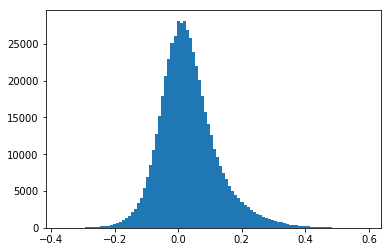

In [155]:
for i in range()    
    h = hist(X[~np.isnan(X)], bins=100)

In [17]:
result = np.array(result)

In [6]:
U, S, Vh = precompute_svd(stimulus[:-500])
np.save('results/USVh', [U, S, Vh])

In [16]:
result.shape

(12524, 100, 36)

This is a linear regression model, so if the response time course for voxel $j$ is $R_j$, the stimulus time course for semantic feature $i$ is $S_i$, and the regression weight for feature $i$ in voxel $j$ is $\beta_{ij}$, then the model can be written as:

$\hat{R}_j = \beta_{0j} S_0 + \beta_{1j} S_1 + \cdots$

or:

$\hat{R}_j = \sum_i \beta_{ij} S_i$

The trick, of course, is accurately estimating the $\beta_j$ values. This is commonly done by minimizing the sum of the squared error (here across time, $t$):

$E_j(\beta) = \sum_t (R_{jt} - \hat{R}_{jt})^2 = \sum_t (R_{jt} - \sum_i \beta_{i} S_{it})^2$

$\beta_j = \underset{\beta}{\operatorname{argmin}} E(\beta)$

Computing \(\beta\) this way is called ordinary least squares (OLS), and this will not work in our case because the total number of features (3940) is smaller than the number of time points (3737). (It would be possible if the number of delays was smaller than 4, but it would give terrible results.. feel free to try it! OLS can be performed using the function np.linalg.lstsq.)

In almost every case, linear regression can be improved by making some prior assumptions about the weights (or, equivalently, about the covariance structure of the stimuli). This is called regularization, or regularized linear regression. One way to do this is to penalize the error function by the sum of the squared weights. This is commonly known as ridge regression, and is a special case of Tikhonov regularization. It finds the \(\beta\) that minimizes the following error function:

$E_j(\beta) = \sum_t (R_{jt} - \sum_i \beta_{i} S_{it})^2 + \alpha \sum_i \beta_i^2$

(In practice we will use a different formulation that involves re-weighting the singular values of the matrix \(S\) before computing its pseudoinverse. This method achieves the same results but is extremely efficient because it uses all the linear algebra machinery that computers are so good at to build many models in parallel.)

In [19]:
alpha_range = range(0, 500, 5)
alpha_range.index(220)

44

In [66]:
import nibabel as nib
folder = '/home/medanya/forrest_gump/fmri/sub003/BOLD/task001_run001'
folder = '/home/medanya/forrest_gump/fmri/sub003/BOLD/task001_run002'

mri0 = nib.load(folder + '/bold_dico_dico7Tad2grpbold7Tad_nl.nii.gz').get_data()
mask = nib.load(folder + '/bold_dico_brainmask_dico7Tad2grpbold7Tad_nl.nii.gz').get_data()
mask2 = nib.load(folder + '/bold_dico_brainmask_dico7Tad2grpbold7Tad_nl.nii.gz').get_data()

In [77]:
mri1 = np.einsum('ijkl, ijk->ijkl', mri0, mask)
print mri0.shape, mask.shape

(132, 175, 48, 441) (132, 175, 48)


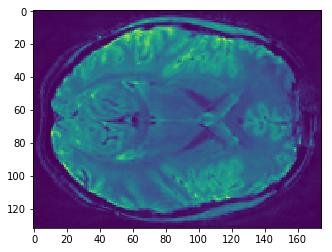

In [78]:
imshow(mri0[:,:, 24, 90])

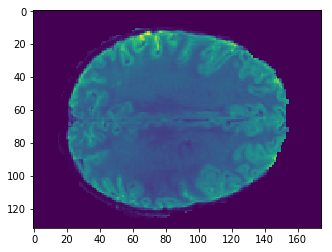

In [79]:
imshow(mri2[:,:, 45, 90])

In [23]:
(result[:, 44, :] > 0.2).sum() * 1. / len(coordinates) / 35.

0.052869918328238355

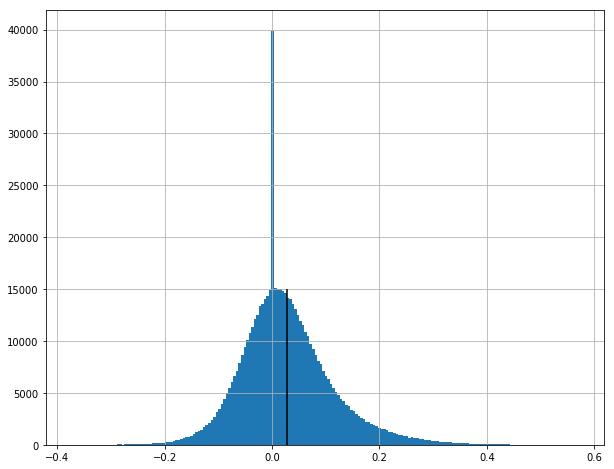

In [27]:
figure(figsize=(10,8))
h = hist(result[:, 44, :].ravel(), bins=200)
vlines(result[:, 44, :].mean(), ymin=0, ymax=15000)
#ylim((0, 16000))
grid()

In [66]:
np.save('sub1_0_500_5_prep', result)

In [9]:
p = Pool(16)
result = p.map(do_ridge, new_coord)

In [ ]:
result = np.array(result)

In [ ]:
result_coord = zip(coordinates, result)

In [ ]:
result

In [ ]:
for i, alpha in enumerate(range(30, 200, 10)):
    title("alpha = {}".format(alpha))
    hist(result[:, i])
    show()

In [ ]:
np.save("result/results2", result_coord)

In [ ]:
print("ok")